# LSDL CUB, seminar 01. Linear probing, fine-tuning & zero-shot

In [ ]:
#!git clone https://github.com/mlfoundations/wise-ft.git

In [2]:
%%bash
mv wise-ft/* .
mv src/wise_ft.py .
mv src/scatter_plot.py .

**Attention!** To run this notebook, put files `banana.jpg`, `scatter_plot.py` from the repo in the same directory. Also replace `cifar10.py` from `src/datasets/cifar10.py` with the new version from the repo.

## Zero-shot predictions

In [1]:
import torch
import clip.clip as clip
import src.templates as templates
from src.models.modeling import ClassificationHead, ImageEncoder, ImageClassifier
from PIL import Image
from types import SimpleNamespace
from tqdm.auto import tqdm

In [80]:
#template='openai_imagenet_template'
args = SimpleNamespace(model='ViT-B/32', device='cuda', cache_dir='cache',
                       template='openai_imagenet_template')

In [81]:
image_encoder = ImageEncoder(args, keep_lang=True)
clip_model = image_encoder.model
device = args.device
clip_model = clip_model.eval().to(device)
template = getattr(templates, args.template)
logit_scale = clip_model.logit_scale

In [82]:
classnames = ['banana', 'apple', 'orange', 'lemon',
              'grapes', 'kiwi', 'mango', 'tomato']

In [83]:
with torch.no_grad():
    zeroshot_weights = []
    for classname in tqdm(classnames):
        texts = []
        for t in template:
            texts.append(t(classname))

        texts = clip.tokenize(texts).to(device) # tokenize
        embeddings = clip_model.encode_text(texts) # embed with text encoder
        embeddings /= embeddings.norm(dim=-1, keepdim=True)

        embeddings = embeddings.mean(dim=0, keepdim=True)
        embeddings /= embeddings.norm()

        zeroshot_weights.append(embeddings)

    zeroshot_weights = torch.stack(zeroshot_weights, dim=0).to(device)
    zeroshot_weights = torch.transpose(zeroshot_weights, 0, 2)

    zeroshot_weights *= logit_scale.exp()

    zeroshot_weights = zeroshot_weights.squeeze().float()
    zeroshot_weights = torch.transpose(zeroshot_weights, 0, 1)

classification_head = ClassificationHead(normalize=True, weights=zeroshot_weights)

  0%|          | 0/9 [00:00<?, ?it/s]

In [84]:
classifier = ImageClassifier(image_encoder, classification_head, process_images=True).to(device)

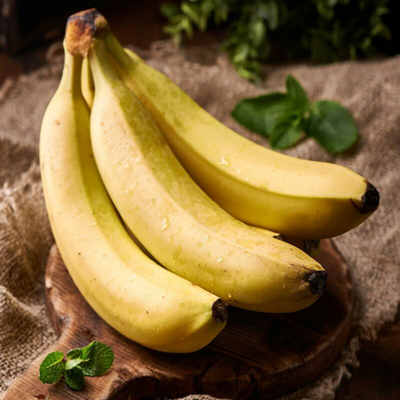

In [89]:
img = Image.open('banana.jpg')
img.resize((400, 400))

In [90]:
img_tensor = classifier.image_encoder.val_preprocess(img).unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [91]:
with torch.no_grad():
    logits = classifier(img_tensor.to(device))
    probs = logits.softmax(dim=-1).squeeze()

values, indices = probs.sort(descending=True)
for val, ind in zip(values, indices):
    print(f'Class {classnames[ind.item()]}: {val.item() * 100:.2f}%')

Class banana: 99.25%
Class mango: 0.47%
Class lemon: 0.23%
Class apple: 0.03%
Class kiwi: 0.01%
Class grapes: 0.01%
Class orange: 0.00%
Class pumpkin: 0.00%
Class tomato: 0.00%


## Download CIFAR-10.1 and CIFAR-10.2 datasets

In [1]:
%%bash
export DATA_LOCATION=~/datasets

# CIFAR10.1
mkdir -p $DATA_LOCATION/CIFAR-10.1
wget https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v6_data.npy -P $DATA_LOCATION/CIFAR-10.1
wget https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v6_labels.npy -P $DATA_LOCATION/CIFAR-10.1

# CIFAR10.2
mkdir -p $DATA_LOCATION/CIFAR-10.2
wget https://github.com/modestyachts/cifar-10.2/raw/61b0e3ac09809a2351379fb54331668cc9c975c4/cifar102_test.npy -P $DATA_LOCATION/CIFAR-10.2
wget https://github.com/modestyachts/cifar-10.2/raw/61b0e3ac09809a2351379fb54331668cc9c975c4/cifar102_train.npy -P $DATA_LOCATION/CIFAR-10.2

--2024-09-09 10:26:36--  https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v6_data.npy
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v6_data.npy [following]
--2024-09-09 10:26:37--  https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v6_data.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6144128 (5,9M) [application/octet-stream]
Saving to: ‘/home/isadrtdinov/datasets/CIFAR-10.1/cifar10.1_v6_data.npy’

     0K .......... .......... .......... .......... ..........  0% 1,20M 5s
    50K .

  4800K .......... .......... .......... .......... .......... 80%  116M 0s
  4850K .......... .......... .......... .......... .......... 81%  107M 0s
  4900K .......... .......... .......... .......... .......... 82%  123M 0s
  4950K .......... .......... .......... .......... .......... 83%  112M 0s
  5000K .......... .......... .......... .......... .......... 84% 95,9M 0s
  5050K .......... .......... .......... .......... .......... 84% 93,2M 0s
  5100K .......... .......... .......... .......... .......... 85%  129M 0s
  5150K .......... .......... .......... .......... .......... 86%  129M 0s
  5200K .......... .......... .......... .......... .......... 87%  123M 0s
  5250K .......... .......... .......... .......... .......... 88%  114M 0s
  5300K .......... .......... .......... .......... .......... 89%  109M 0s
  5350K .......... .......... .......... .......... .......... 89%  101M 0s
  5400K .......... .......... .......... .......... .......... 90%  131M 0s
  5450K ....

  2700K .......... .......... .......... .......... .......... 31%  107M 0s
  2750K .......... .......... .......... .......... .......... 31% 80,2M 0s
  2800K .......... .......... .......... .......... .......... 32%  111M 0s
  2850K .......... .......... .......... .......... .......... 32% 59,8M 0s
  2900K .......... .......... .......... .......... .......... 33% 91,2M 0s
  2950K .......... .......... .......... .......... .......... 33% 83,9M 0s
  3000K .......... .......... .......... .......... .......... 34% 73,2M 0s
  3050K .......... .......... .......... .......... .......... 34% 86,4M 0s
  3100K .......... .......... .......... .......... .......... 35%  116M 0s
  3150K .......... .......... .......... .......... .......... 36% 72,1M 0s
  3200K .......... .......... .......... .......... .......... 36% 68,1M 0s
  3250K .......... .......... .......... .......... .......... 37%  110M 0s
  3300K .......... .......... .......... .......... .......... 37%  127M 0s
  3350K ....

  8100K .......... .......... .......... .......... .......... 91% 93,9M 0s
  8150K .......... .......... .......... .......... .......... 92%  122M 0s
  8200K .......... .......... .......... .......... .......... 93%  106M 0s
  8250K .......... .......... .......... .......... .......... 93%  119M 0s
  8300K .......... .......... .......... .......... .......... 94%  100M 0s
  8350K .......... .......... .......... .......... .......... 94%  130M 0s
  8400K .......... .......... .......... .......... .......... 95%  128M 0s
  8450K .......... .......... .......... .......... .......... 95% 95,2M 0s
  8500K .......... .......... .......... .......... .......... 96%  110M 0s
  8550K .......... .......... .......... .......... .......... 96%  106M 0s
  8600K .......... .......... .......... .......... .......... 97%  123M 0s
  8650K .......... .......... .......... .......... .......... 98%  126M 0s
  8700K .......... .......... .......... .......... .......... 98%  109M 0s
  8750K ....

  3900K .......... .......... .......... .......... ..........  8%  136M 3s
  3950K .......... .......... .......... .......... ..........  9%  127M 3s
  4000K .......... .......... .......... .......... ..........  9%  106M 3s
  4050K .......... .......... .......... .......... ..........  9%  119M 3s
  4100K .......... .......... .......... .......... ..........  9%  127M 3s
  4150K .......... .......... .......... .......... ..........  9% 95,5M 3s
  4200K .......... .......... .......... .......... ..........  9% 94,5M 2s
  4250K .......... .......... .......... .......... ..........  9% 79,5M 2s
  4300K .......... .......... .......... .......... ..........  9%  144M 2s
  4350K .......... .......... .......... .......... ..........  9%  106M 2s
  4400K .......... .......... .......... .......... .......... 10%  123M 2s
  4450K .......... .......... .......... .......... .......... 10%  112M 2s
  4500K .......... .......... .......... .......... .......... 10%  109M 2s
  4550K ....

  9300K .......... .......... .......... .......... .......... 21%  108M 1s
  9350K .......... .......... .......... .......... .......... 21% 93,4M 1s
  9400K .......... .......... .......... .......... .......... 21% 75,1M 1s
  9450K .......... .......... .......... .......... .......... 21%  129M 1s
  9500K .......... .......... .......... .......... .......... 21% 94,5M 1s
  9550K .......... .......... .......... .......... .......... 21%  118M 1s
  9600K .......... .......... .......... .......... .......... 21% 93,6M 1s
  9650K .......... .......... .......... .......... .......... 21% 64,6M 1s
  9700K .......... .......... .......... .......... .......... 22%  115M 1s
  9750K .......... .......... .......... .......... .......... 22% 75,2M 1s
  9800K .......... .......... .......... .......... .......... 22%  125M 1s
  9850K .......... .......... .......... .......... .......... 22%  111M 1s
  9900K .......... .......... .......... .......... .......... 22%  125M 1s
  9950K ....

 14700K .......... .......... .......... .......... .......... 33% 7,95M 1s
 14750K .......... .......... .......... .......... .......... 33% 28,7M 1s
 14800K .......... .......... .......... .......... .......... 33% 43,4M 1s
 14850K .......... .......... .......... .......... .......... 33%  116M 1s
 14900K .......... .......... .......... .......... .......... 33%  116M 1s
 14950K .......... .......... .......... .......... .......... 33%  104M 1s
 15000K .......... .......... .......... .......... .......... 33%  115M 1s
 15050K .......... .......... .......... .......... .......... 34%  109M 1s
 15100K .......... .......... .......... .......... .......... 34%  122M 1s
 15150K .......... .......... .......... .......... .......... 34% 88,2M 1s
 15200K .......... .......... .......... .......... .......... 34%  118M 1s
 15250K .......... .......... .......... .......... .......... 34%  111M 1s
 15300K .......... .......... .......... .......... .......... 34%  118M 1s
 15350K ....

 20100K .......... .......... .......... .......... .......... 45%  109M 1s
 20150K .......... .......... .......... .......... .......... 45%  105M 1s
 20200K .......... .......... .......... .......... .......... 45% 96,3M 1s
 20250K .......... .......... .......... .......... .......... 45% 65,5M 1s
 20300K .......... .......... .......... .......... .......... 45%  117M 1s
 20350K .......... .......... .......... .......... .......... 46%  116M 1s
 20400K .......... .......... .......... .......... .......... 46%  130M 1s
 20450K .......... .......... .......... .......... .......... 46% 92,3M 1s
 20500K .......... .......... .......... .......... .......... 46%  122M 1s
 20550K .......... .......... .......... .......... .......... 46%  113M 1s
 20600K .......... .......... .......... .......... .......... 46%  112M 1s
 20650K .......... .......... .......... .......... .......... 46%  117M 1s
 20700K .......... .......... .......... .......... .......... 46%  117M 1s
 20750K ....

 25500K .......... .......... .......... .......... .......... 57%  115M 0s
 25550K .......... .......... .......... .......... .......... 57%  109M 0s
 25600K .......... .......... .......... .......... .......... 57%  118M 0s
 25650K .......... .......... .......... .......... .......... 58% 94,4M 0s
 25700K .......... .......... .......... .......... .......... 58%  114M 0s
 25750K .......... .......... .......... .......... .......... 58%  111M 0s
 25800K .......... .......... .......... .......... .......... 58%  118M 0s
 25850K .......... .......... .......... .......... .......... 58% 90,6M 0s
 25900K .......... .......... .......... .......... .......... 58% 87,6M 0s
 25950K .......... .......... .......... .......... .......... 58%  103M 0s
 26000K .......... .......... .......... .......... .......... 58%  111M 0s
 26050K .......... .......... .......... .......... .......... 58%  105M 0s
 26100K .......... .......... .......... .......... .......... 59% 97,3M 0s
 26150K ....

 30900K .......... .......... .......... .......... .......... 69% 71,9M 0s
 30950K .......... .......... .......... .......... .......... 69%  134M 0s
 31000K .......... .......... .......... .......... .......... 70%  120M 0s
 31050K .......... .......... .......... .......... .......... 70% 99,8M 0s
 31100K .......... .......... .......... .......... .......... 70%  121M 0s
 31150K .......... .......... .......... .......... .......... 70% 76,9M 0s
 31200K .......... .......... .......... .......... .......... 70%  109M 0s
 31250K .......... .......... .......... .......... .......... 70%  109M 0s
 31300K .......... .......... .......... .......... .......... 70% 80,1M 0s
 31350K .......... .......... .......... .......... .......... 70%  126M 0s
 31400K .......... .......... .......... .......... .......... 70% 87,9M 0s
 31450K .......... .......... .......... .......... .......... 71% 92,3M 0s
 31500K .......... .......... .......... .......... .......... 71%  126M 0s
 31550K ....

 36300K .......... .......... .......... .......... .......... 82%  127M 0s
 36350K .......... .......... .......... .......... .......... 82%  122M 0s
 36400K .......... .......... .......... .......... .......... 82% 96,1M 0s
 36450K .......... .......... .......... .......... .......... 82%  101M 0s
 36500K .......... .......... .......... .......... .......... 82%  117M 0s
 36550K .......... .......... .......... .......... .......... 82% 53,7M 0s
 36600K .......... .......... .......... .......... .......... 82% 99,4M 0s
 36650K .......... .......... .......... .......... .......... 82%  102M 0s
 36700K .......... .......... .......... .......... .......... 82%  135M 0s
 36750K .......... .......... .......... .......... .......... 83%  117M 0s
 36800K .......... .......... .......... .......... .......... 83% 69,1M 0s
 36850K .......... .......... .......... .......... .......... 83% 95,0M 0s
 36900K .......... .......... .......... .......... .......... 83%  126M 0s
 36950K ....

 41700K .......... .......... .......... .......... .......... 94% 91,9M 0s
 41750K .......... .......... .......... .......... .......... 94%  124M 0s
 41800K .......... .......... .......... .......... .......... 94% 82,5M 0s
 41850K .......... .......... .......... .......... .......... 94% 99,8M 0s
 41900K .......... .......... .......... .......... .......... 94% 27,7M 0s
 41950K .......... .......... .......... .......... .......... 94% 31,1M 0s
 42000K .......... .......... .......... .......... .......... 94% 79,5M 0s
 42050K .......... .......... .......... .......... .......... 95% 34,6M 0s
 42100K .......... .......... .......... .......... .......... 95% 22,5M 0s
 42150K .......... .......... .......... .......... .......... 95% 35,7M 0s
 42200K .......... .......... .......... .......... .......... 95% 77,6M 0s
 42250K .......... .......... .......... .......... .......... 95% 85,6M 0s
 42300K .......... .......... .......... .......... .......... 95% 45,0M 0s
 42350K ....

## Fine-tune model and create a weight ensemble

### Linear probing + weight ensemble

In [86]:
!/home/isadrtdinov/anaconda3/envs/wiseft/bin/python wise_ft.py   \
    --train-dataset=CIFAR10  \
    --epochs=10  \
    --lr=1e-3  \
    --batch-size=128  \
    --cache-dir=cache  \
    --model=ViT-B/32  \
    --freeze-encoder  \
    --eval-datasets=CIFAR10,CIFAR101,CIFAR102,STL10  \
    --template=simple_template  \
    --results-db=results_lp.json  \
    --save=models/wiselp/ViTB32  \
    --data-location=/home/isadrtdinov/datasets \
    --alpha 0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

Files already downloaded and verified
Files already downloaded and verified
Getting zeroshot weights.
100%|###########################################| 10/10 [00:00<00:00, 35.57it/s]
Saving image classifier to models/wiselp/ViTB32/zeroshot.pt
Loading image classifier from models/wiselp/ViTB32/zeroshot.pt
Fine-tuning a linear classifier
Files already downloaded and verified
Files already downloaded and verified
Using devices [0, 1]
Getting features from cache/CIFAR10/train
Train Epoch: 0 [0% 0/391]	Loss: 0.351483	Data (t) 0.000	Batch (t) 1.759
Saving model to models/wiselp/ViTB32/finetuned/checkpoint_1.pt
Saving image classifier to models/wiselp/ViTB32/finetuned/checkpoint_1.pt
Evaluating on CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Getting features from cache/CIFAR10/val
CIFAR10 Top-1 accuracy: 0.9106
Evaluating on CIFAR101
Getting features from cache/CIFAR101/val
CIFAR101 Top-1 accuracy: 0.8675
Evaluating on CIFAR102
Getting features from cach

Loading image classifier from models/wiselp/ViTB32/finetuned/checkpoint_10.pt
Saving image classifier to models/wiselp/ViTB32/finetuned/wise_ft_alpha=0.000.pt
Evaluating on CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Getting features from cache/CIFAR10/val
CIFAR10 Top-1 accuracy: 0.8830
Evaluating on CIFAR101
Getting features from cache/CIFAR101/val
CIFAR101 Top-1 accuracy: 0.8285
Evaluating on CIFAR102
Getting features from cache/CIFAR102/val
CIFAR102 Top-1 accuracy: 0.7925
Evaluating on STL10
Files already downloaded and verified
Getting features from cache/STL10/val
STL10 Top-1 accuracy: 0.8765
Results saved to results_lp.json.
Saving image classifier to models/wiselp/ViTB32/finetuned/wise_ft_alpha=0.100.pt
Evaluating on CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Getting features from cache/CIFAR10/val
CIFAR10 Top-1 accuracy: 0.8928
Evaluating on CIFAR101
Getting features from cache/CIFAR101/val
CIFAR10

In [88]:
!/home/isadrtdinov/anaconda3/envs/wiseft/bin/python scatter_plot.py  \
    --train-dataset=CIFAR10  \
    --eval-datasets=CIFAR101,CIFAR102,STL10  \
    --results-db=results_lp.json  \
    --save plots_lp

### Results for CIFAR-10.1

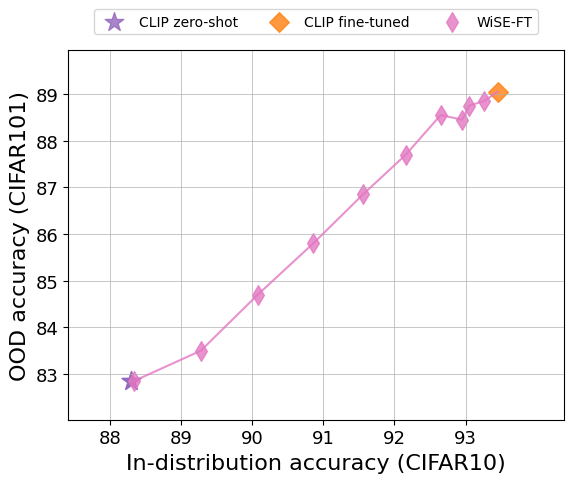

In [92]:
Image.open('plots_lp/CIFAR101.png')

### Results for STL-10

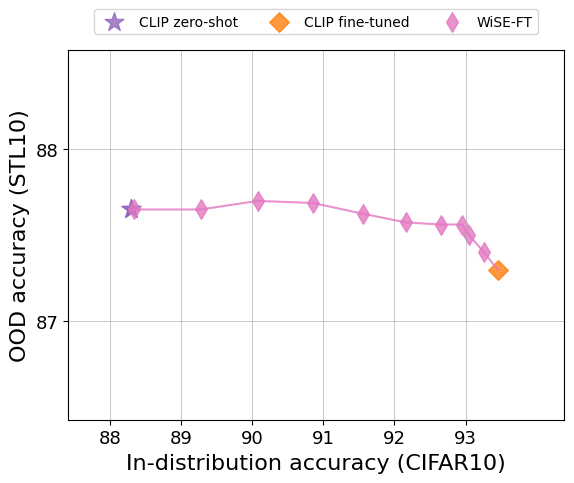

In [93]:
Image.open('plots_lp/STL10.png')

### Full fine-tuning + weight ensemble

In [89]:
!/home/isadrtdinov/anaconda3/envs/wiseft/bin/python wise_ft.py   \
    --train-dataset=CIFAR10  \
    --epochs=10  \
    --lr=5e-6  \
    --batch-size=128  \
    --cache-dir=cache  \
    --model=ViT-B/32  \
    --eval-datasets=CIFAR10,CIFAR101,CIFAR102,STL10  \
    --template=simple_template  \
    --results-db=results_ft.json  \
    --save=models/wiseft/ViTB32  \
    --data-location=/home/isadrtdinov/datasets \
    --alpha 0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

Files already downloaded and verified
Files already downloaded and verified
Getting zeroshot weights.
100%|###########################################| 10/10 [00:00<00:00, 37.63it/s]
Saving image classifier to models/wiseft/ViTB32/zeroshot.pt
Loading image classifier from models/wiseft/ViTB32/zeroshot.pt
Fine-tuning end-to-end
Files already downloaded and verified
Files already downloaded and verified
Using devices [0, 1]
Train Epoch: 0 [0% 0/391]	Loss: 0.330556	Data (t) 0.028	Batch (t) 2.779
Train Epoch: 0 [26% 100/391]	Loss: 0.151856	Data (t) 0.017	Batch (t) 0.458
Train Epoch: 0 [51% 200/391]	Loss: 0.137027	Data (t) 0.017	Batch (t) 0.462
Train Epoch: 0 [77% 300/391]	Loss: 0.037634	Data (t) 0.017	Batch (t) 0.473
Saving model to models/wiseft/ViTB32/finetuned/checkpoint_1.pt
Saving image classifier to models/wiseft/ViTB32/finetuned/checkpoint_1.pt
Evaluating on CIFAR10
Files already downloaded and verified
Files already downloaded and verified
CIFAR10 Top-1 accuracy: 0.9675
Evaluating 

CIFAR102 Top-1 accuracy: 0.9135
Evaluating on STL10
Files already downloaded and verified
STL10 Top-1 accuracy: 0.8690
Results saved to results_ft.json.
Loading image classifier from models/wiseft/ViTB32/zeroshot.pt
Loading image classifier from models/wiseft/ViTB32/finetuned/checkpoint_10.pt
Saving image classifier to models/wiseft/ViTB32/finetuned/wise_ft_alpha=0.000.pt
Evaluating on CIFAR10
Files already downloaded and verified
Files already downloaded and verified
CIFAR10 Top-1 accuracy: 0.8830
Evaluating on CIFAR101
CIFAR101 Top-1 accuracy: 0.8285
Evaluating on CIFAR102
CIFAR102 Top-1 accuracy: 0.7925
Evaluating on STL10
Files already downloaded and verified
STL10 Top-1 accuracy: 0.8765
Results saved to results_ft.json.
Saving image classifier to models/wiseft/ViTB32/finetuned/wise_ft_alpha=0.100.pt
Evaluating on CIFAR10
Files already downloaded and verified
Files already downloaded and verified
CIFAR10 Top-1 accuracy: 0.9273
Evaluating on CIFAR101
CIFAR101 Top-1 accuracy: 0.8880


In [90]:
!/home/isadrtdinov/anaconda3/envs/wiseft/bin/python scatter_plot.py  \
    --train-dataset=CIFAR10  \
    --eval-datasets=CIFAR101,CIFAR102,STL10  \
    --results-db=results_ft.json  \
    --save plots_ft

### Results for CIFAR-10.1

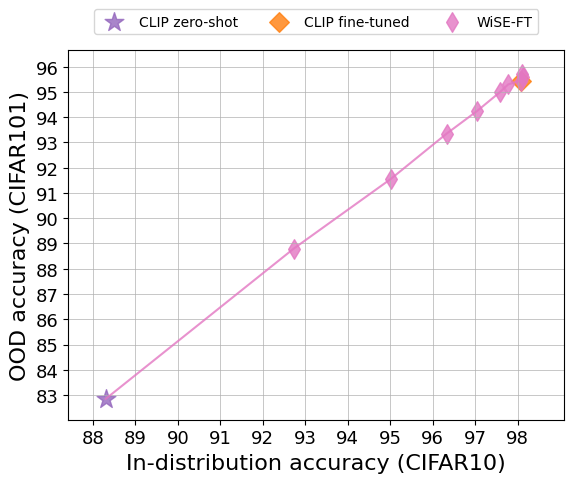

In [96]:
Image.open('plots_ft/CIFAR101.png')

### Results for STL-10

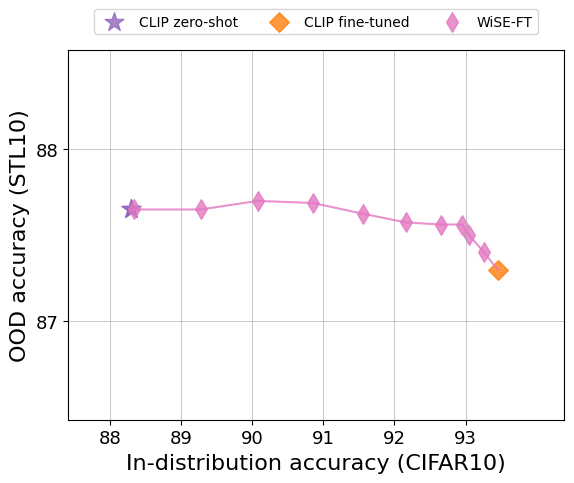

In [97]:
Image.open('plots_lp/STL10.png')